In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from collections.abc import Callable
from typing import Literal
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()


def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

In [3]:
inpDir = 'D:\DNN\input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'D:\DNN\images' # location of the images
modelDir = '../models'
altName = '?????'

RANDOM_STATE = 24
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed=RANDOM_STATE)
EPOCHS = 101 # number of epochs
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
BATCH_SIZE = 32
REG_LAMBDA = 0.001
# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [4]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape


(18207, 89)

In [5]:
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [6]:
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [7]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [8]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [9]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [10]:
class_labels = {0: 'GK', 1: 'Defender', 2: 'Mid Fielder', 3 : 'Forward'}

In [11]:
y = data_df["Position"].to_numpy()

X = data_df.drop("Position", axis = 1)

X.shape, y.shape

((18147, 33), (18147,))

In [12]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517,) (3630, 33) (3630,)


In [13]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [14]:

k_init = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

k_reg = None
dor1 = 0.02
dor2 = 0.15
dor3 = 0.25
dor4 = 0.35
#k_reg = tf.keras.regularizers.L2(l2 = REG_LAMBDA)
model = tf.keras.Sequential([ 
    tf.keras.layers.InputLayer(shape = (33,)),

    tf.keras.layers.Dense(33, activation='relu',kernel_initializer = k_init , kernel_regularizer=k_reg),
    tf.keras.layers.Dropout(dor1),
    
    tf.keras.layers.Dense(23, activation='relu',kernel_initializer = k_init , kernel_regularizer=k_reg),
    tf.keras.layers.Dropout(dor2),

    tf.keras.layers.Dense(12, activation='relu',kernel_initializer = k_init , kernel_regularizer=k_reg),
    tf.keras.layers.Dropout(dor3),

    tf.keras.layers.Dense(4, activation='relu',kernel_initializer = k_init , kernel_regularizer=k_reg),
    tf.keras.layers.Dropout(dor4),

    tf.keras.layers.Dense(4)
    
])

In [15]:
model(X_train[:1])

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.08726155, -0.17534368, -0.0222055 , -0.12340184]],
      dtype=float32)>

In [16]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

In [17]:
model.compile(optimizer=optimizer, loss = loss_fn , metrics=['accuracy'])

history = model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=BATCH_SIZE,epochs=EPOCHS,verbose=2)

Epoch 1/101
454/454 - 4s - 8ms/step - accuracy: 0.5409 - loss: 0.9942 - val_accuracy: 0.8168 - val_loss: 0.6437
Epoch 2/101
454/454 - 1s - 3ms/step - accuracy: 0.7263 - loss: 0.7265 - val_accuracy: 0.8474 - val_loss: 0.4755
Epoch 3/101
454/454 - 1s - 3ms/step - accuracy: 0.7476 - loss: 0.6399 - val_accuracy: 0.8540 - val_loss: 0.4255
Epoch 4/101
454/454 - 2s - 4ms/step - accuracy: 0.7608 - loss: 0.5948 - val_accuracy: 0.8614 - val_loss: 0.3921
Epoch 5/101
454/454 - 2s - 4ms/step - accuracy: 0.7646 - loss: 0.5776 - val_accuracy: 0.8656 - val_loss: 0.3709
Epoch 6/101
454/454 - 1s - 3ms/step - accuracy: 0.7747 - loss: 0.5598 - val_accuracy: 0.8620 - val_loss: 0.3677
Epoch 7/101
454/454 - 2s - 3ms/step - accuracy: 0.7817 - loss: 0.5520 - val_accuracy: 0.8598 - val_loss: 0.3586
Epoch 8/101
454/454 - 2s - 3ms/step - accuracy: 0.7920 - loss: 0.5419 - val_accuracy: 0.8612 - val_loss: 0.3595
Epoch 9/101
454/454 - 2s - 4ms/step - accuracy: 0.7980 - loss: 0.5254 - val_accuracy: 0.8565 - val_loss:

In [18]:

def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss 
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y2 = hist_df.columns[0] 
    y1 = hist_df.columns[1] 
    y4 = hist_df.columns[2]
    y3 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

    

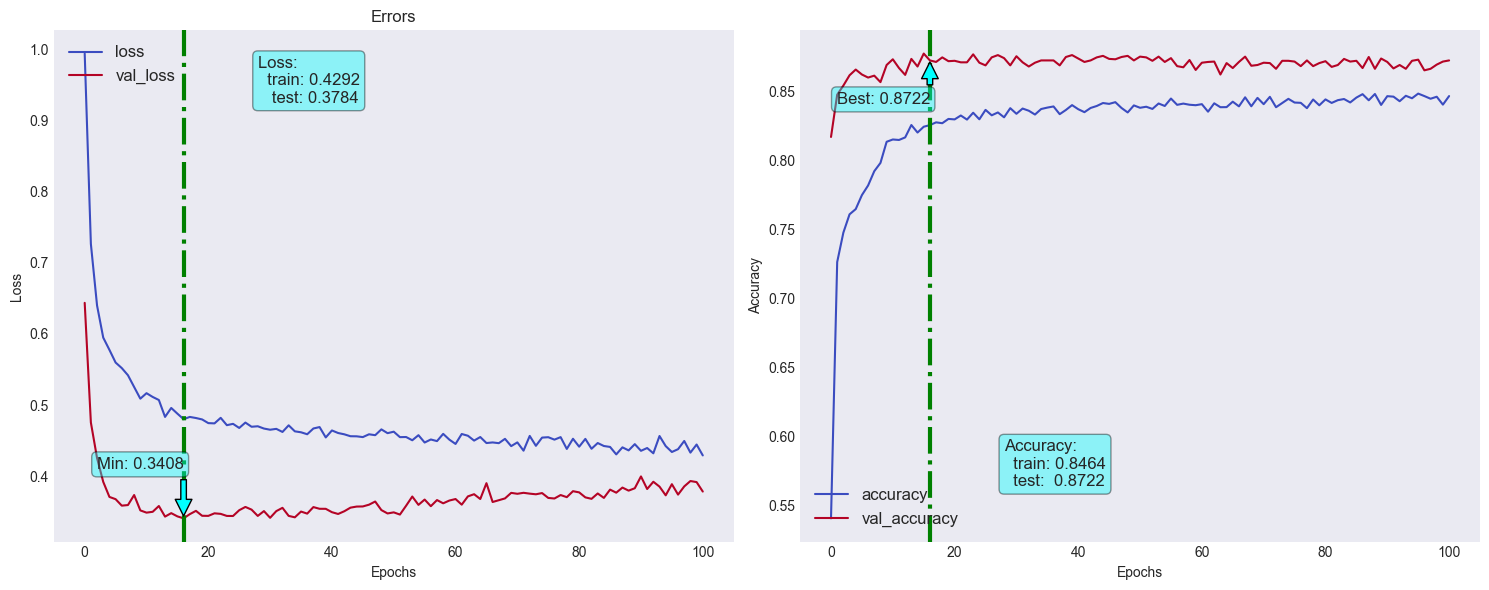

In [19]:

fn_plot_tf_hist(pd.DataFrame(history.history))

In [20]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.540883,0.994156,0.816804,0.643711
1,0.726321,0.726528,0.847383,0.475470
2,0.747606,0.639941,0.853994,0.425532
3,0.760832,0.594839,0.861432,0.392086
4,0.764621,0.577642,0.865565,0.370894


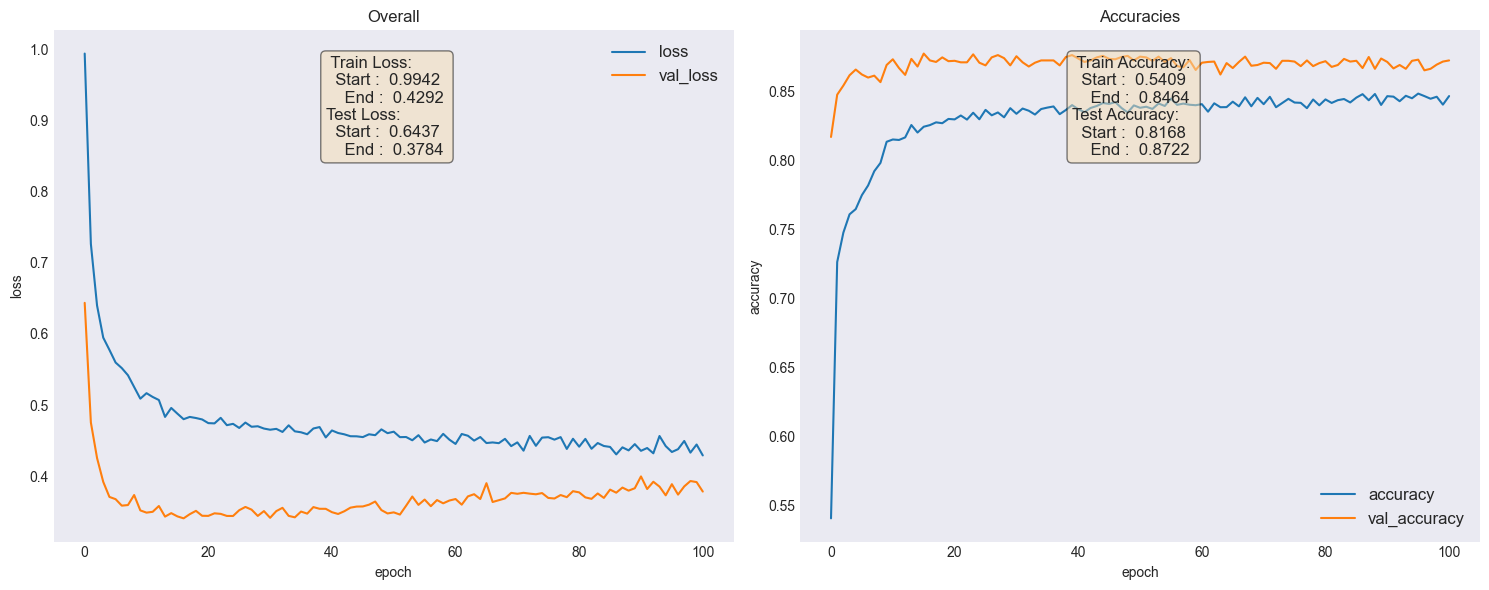

In [21]:
fig, axes = plt.subplots(1,2 , figsize = (15,6),)

l_range = 10 # ignoring first few records
y1_var = 'loss'
y2_var = 'val_loss'

ax = axes[0]

loss_df[[y1_var, y2_var]].plot( ax = ax)

# get values for plotting
st_loss = loss_df[y1_var].iloc[0]
end_loss = loss_df[y1_var].iloc[-1]
t_st_loss = loss_df[y2_var].iloc[0]
t_end_loss = loss_df[y2_var].iloc[-1]

# little beautification
train_txtstr = "Train Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot

test_txtstr = "Test Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot
txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_xlabel('epoch')
ax.set_ylabel(y1_var)
ax.set_title('Overall')
ax.grid();

ax = axes[1]

y1_var = 'accuracy'
y2_var = 'val_accuracy'

loss_df[[y1_var, y2_var]].plot( ax = ax)

# get values for plotting
st_loss = loss_df[y1_var].iloc[0]
end_loss = loss_df[y1_var].iloc[-1]
t_st_loss = loss_df[y2_var].iloc[0]
t_end_loss = loss_df[y2_var].iloc[-1]

# little beautification
train_txtstr = "Train Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot

test_txtstr = "Test Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot# properties  matplotlib.patch.Patch 
txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_xlabel('epoch')
ax.set_ylabel(y1_var)
ax.set_title('Accuracies'.format(l_range))
ax.grid();
plt.tight_layout()